# 개구리는 안돼요(CIFAR-10)
- 이상감지용 데이터셋 구축 (개구리 데이터를 학습데이터셋에서 제외하여 테스트 데이터셋에 포함)
- Skip-GANomaly 모델의 구현
- 모델의 학습과 검증
- 검증 결과의 시각화 (정상-이상 데이터의 anomaly score 분포 시각화, 적절한 threshold에 따른 이삼감지율 계산, 감지 성공/실패사례 시각화 포함)



1. Anomaly Detection 태스크 특성에 맞도록 데이터셋 가공이 진행되었다.- 개구리 클래스가 배제되어 테스트셋에만 반영되는 로직이 구현되었다.

2. Skip-GANomaly 모델이 정상적으로 구현되었다. - 모델 학습 및 테스트가 원활하게 진행되었다.

3. 이상감지 수행 결과가 체계적으로 시각화되었다. - Anomaly score 분호, 테스트셋 이상감지 정확도(%), 이상감지 성공실패사례 제시가 진행되었다.


# library import

In [24]:
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display

# data import
- 시파 10
- https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data

In [94]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

In [95]:
train_data[0].shape

# 시파 데이터는 원래 32이라 패딩처리 안해줘도 될듯....

(32, 32, 3)

In [96]:


train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

from PIL import Image

# 시파 데이터는 원래 32이라 패딩처리 안해줘도 될듯....

# Fashion MNIST padding to 32 X 32
# train_data_32 = np.zeros((train_data.shape[0], 32, 32)).astype('float32')
# test_data_32 = np.zeros((test_data.shape[0], 32, 32)).astype('float32')     
# train_data_32[:, 2:30, 2:30] = train_data
# test_data_32[:, 2:30, 2:30] = test_data

# 1channel data reshape
#train_data = train_data_32.reshape(train_data_32.shape[0], 32, 32, 1).astype('float32')
#test_data = test_data_32.reshape(test_data_32.shape[0], 32, 32, 1).astype('float32')

print(train_data.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


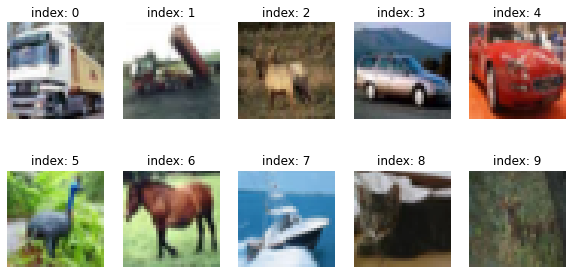

In [105]:
# 이미지 출력해보기
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_data[i] + 1) / 2)
    #plt.imshow(train_data[i].reshape(32, 32,3), cmap='gray') # chanel add
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

# data 전처리
- 개구리 빼기

## 개구리 숙청

In [106]:
# 개구리 0으로 나머지 1
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:   # frog 6
            new_t_labels.append([0])  # frog 이상치로 처리
        else:
            new_t_labels.append([1])  # 그 외의 경우는 정상치
             
    return np.array(new_t_labels)

In [107]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [108]:
# label 0을 anmaly data로
# 나머지는 nomaly data 로분류


normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [109]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(40488, 32, 32, 3) (40488, 1)
(4512, 32, 32, 3) (4512, 1)


In [110]:
#train data / label은 0말 고 나머지
#test data /label은 0인 넘들.....

train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run ConcatV2: Dst tensor is not initialized. [Op:ConcatV2] name: concat

In [ ]:
print(train_data.shape)
print(test_data.shape)

In [ ]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

In [ ]:
# train 라벨이 0 있는 지 혹시나 체크
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

In [111]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

# from_tensor_slices tensor data set<으로

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
# 
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [112]:
for data, label in train_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [113]:
for data, label in test_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]], shape=(8, 1), dtype=int64)


# model 
- Skip-GANomaly 모델
- 학습과 검증.

## skip - ganomaly model

In [114]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [115]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False,
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [116]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel=3):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(512) # 1
        
        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16
        
        self.output_layer = layers.Conv2DTranspose(3, 1, strides=2, padding='same', use_bias=False, # 32
                                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))
                
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

In [117]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                          use_bias=False, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

In [118]:
generator = Generator()  # Generator가 32X32X3 짜리 이미지를 생성해야 합니다. 
discriminator = Discriminator()

## loss fn

In [119]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [120]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

In [121]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    return total_gen_loss

## optimizer

In [122]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

## train

In [123]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [124]:
checkpoint_path = os.path.join(os.getenv('HOME'),'lsg/data/ganomaly_skip_no_norm/ckpt2')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
max_epochs = 25
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_path)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

Steps : 100, 	 Total Gen Loss : 25.707839965820312, 	 Total Dis Loss : 0.003551802597939968
Steps : 200, 	 Total Gen Loss : 24.79598617553711, 	 Total Dis Loss : 0.0003493150870781392
Steps : 300, 	 Total Gen Loss : 26.161685943603516, 	 Total Dis Loss : 0.0015247530536726117
Steps : 400, 	 Total Gen Loss : 27.185638427734375, 	 Total Dis Loss : 0.0013578709913417697
Steps : 500, 	 Total Gen Loss : 24.212200164794922, 	 Total Dis Loss : 0.0004940439248457551
Steps : 600, 	 Total Gen Loss : 24.297319412231445, 	 Total Dis Loss : 0.0019472914282232523
Steps : 700, 	 Total Gen Loss : 23.563276290893555, 	 Total Dis Loss : 0.0008965599117800593
Steps : 800, 	 Total Gen Loss : 25.18674659729004, 	 Total Dis Loss : 0.0005192462704144418
Steps : 900, 	 Total Gen Loss : 24.09900665283203, 	 Total Dis Loss : 0.0007947352714836597
Steps : 1000, 	 Total Gen Loss : 27.18342399597168, 	 Total Dis Loss : 0.0003617573529481888
Steps : 1100, 	 Total Gen Loss : 24.862091064453125, 	 Total Dis Loss : 0.

Steps : 8900, 	 Total Gen Loss : 25.17047119140625, 	 Total Dis Loss : 0.0019136087503284216
Steps : 9000, 	 Total Gen Loss : 31.339120864868164, 	 Total Dis Loss : 0.0005587367340922356
Steps : 9100, 	 Total Gen Loss : 29.846405029296875, 	 Total Dis Loss : 0.004605730064213276
Steps : 9200, 	 Total Gen Loss : 26.2437744140625, 	 Total Dis Loss : 0.0032458326313644648
Steps : 9300, 	 Total Gen Loss : 27.638938903808594, 	 Total Dis Loss : 0.00026080606039613485
Steps : 9400, 	 Total Gen Loss : 28.293758392333984, 	 Total Dis Loss : 0.007191487587988377
Steps : 9500, 	 Total Gen Loss : 29.186870574951172, 	 Total Dis Loss : 0.0005212407559156418
Steps : 9600, 	 Total Gen Loss : 30.89299774169922, 	 Total Dis Loss : 0.00467434898018837
Steps : 9700, 	 Total Gen Loss : 26.316516876220703, 	 Total Dis Loss : 0.0007396923610940576
Steps : 9800, 	 Total Gen Loss : 29.081005096435547, 	 Total Dis Loss : 0.0003429981879889965
Steps : 9900, 	 Total Gen Loss : 26.48247528076172, 	 Total Dis Los

Steps : 17500, 	 Total Gen Loss : 24.28403091430664, 	 Total Dis Loss : 0.0017495908541604877
Steps : 17600, 	 Total Gen Loss : 22.93474578857422, 	 Total Dis Loss : 0.00048447868903167546
Steps : 17700, 	 Total Gen Loss : 24.990676879882812, 	 Total Dis Loss : 0.00044482116936706007
Steps : 17800, 	 Total Gen Loss : 29.12395668029785, 	 Total Dis Loss : 0.00030158457229845226
Steps : 17900, 	 Total Gen Loss : 26.112455368041992, 	 Total Dis Loss : 0.001186872599646449
Steps : 18000, 	 Total Gen Loss : 28.659814834594727, 	 Total Dis Loss : 0.008055153302848339
Steps : 18100, 	 Total Gen Loss : 29.674346923828125, 	 Total Dis Loss : 0.00019974519091192633
Steps : 18200, 	 Total Gen Loss : 24.64980697631836, 	 Total Dis Loss : 0.07939618825912476
Steps : 18300, 	 Total Gen Loss : 24.977481842041016, 	 Total Dis Loss : 0.00016954506281763315
Steps : 18400, 	 Total Gen Loss : 23.38817024230957, 	 Total Dis Loss : 0.00042377039790153503
Steps : 18500, 	 Total Gen Loss : 24.128955841064453,

Steps : 26100, 	 Total Gen Loss : 27.0240421295166, 	 Total Dis Loss : 0.0006353268399834633
Steps : 26200, 	 Total Gen Loss : 25.051101684570312, 	 Total Dis Loss : 0.00019677740056067705
Steps : 26300, 	 Total Gen Loss : 26.839340209960938, 	 Total Dis Loss : 0.00022747932234779
Steps : 26400, 	 Total Gen Loss : 25.804790496826172, 	 Total Dis Loss : 0.0009902111487463117
Steps : 26500, 	 Total Gen Loss : 26.879669189453125, 	 Total Dis Loss : 0.0006001226138323545
Steps : 26600, 	 Total Gen Loss : 23.54303741455078, 	 Total Dis Loss : 0.0006711580790579319
Steps : 26700, 	 Total Gen Loss : 27.70610809326172, 	 Total Dis Loss : 0.00035987840965390205
Steps : 26800, 	 Total Gen Loss : 27.922977447509766, 	 Total Dis Loss : 0.0004111452726647258
Steps : 26900, 	 Total Gen Loss : 30.049850463867188, 	 Total Dis Loss : 0.0002042816486209631
Steps : 27000, 	 Total Gen Loss : 28.431766510009766, 	 Total Dis Loss : 0.000315667362883687
Steps : 27100, 	 Total Gen Loss : 27.672895431518555, 	

Steps : 34800, 	 Total Gen Loss : 25.600135803222656, 	 Total Dis Loss : 6.937257421668619e-05
Steps : 34900, 	 Total Gen Loss : 26.53665542602539, 	 Total Dis Loss : 0.00018286722479388118
Steps : 35000, 	 Total Gen Loss : 24.63595199584961, 	 Total Dis Loss : 0.00019140058429911733
Steps : 35100, 	 Total Gen Loss : 24.040531158447266, 	 Total Dis Loss : 0.0008563511073589325
Steps : 35200, 	 Total Gen Loss : 26.12249183654785, 	 Total Dis Loss : 0.00023493407934438437
Steps : 35300, 	 Total Gen Loss : 27.526308059692383, 	 Total Dis Loss : 0.0002685208455659449
Steps : 35400, 	 Total Gen Loss : 27.00922393798828, 	 Total Dis Loss : 0.00024888073676265776
Time for epoch 7 is 394.70217061042786 sec
Steps : 35500, 	 Total Gen Loss : 27.576560974121094, 	 Total Dis Loss : 7.442822243319824e-05
Steps : 35600, 	 Total Gen Loss : 23.108787536621094, 	 Total Dis Loss : 0.0001755041303113103
Steps : 35700, 	 Total Gen Loss : 24.195289611816406, 	 Total Dis Loss : 0.0027249781414866447


# 결과 시각화

In [134]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [135]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [136]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

10000 10000


In [137]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(1000,)


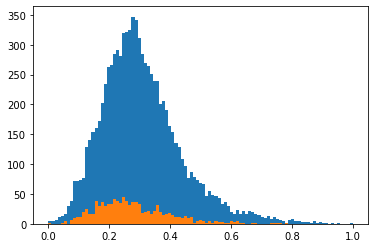

In [138]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

0.3068766 0.27786785
0.13338543 0.1236175


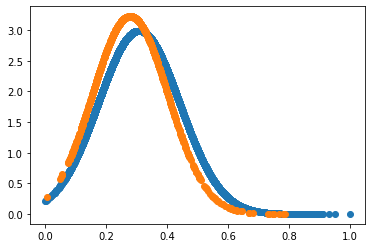

In [139]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))

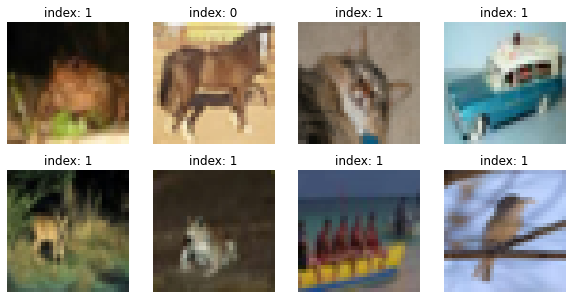

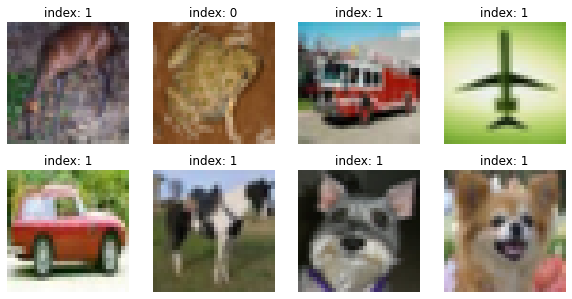

In [140]:

test1 = test_dataset.take(2)
an_scores1, gt_labels1 = _evaluate(test1)

for imgs, labels in test1:
    plt.figure(figsize=(10, 5))
    
    for i in range(len(imgs)):
        plt.subplot(2, 4, i + 1)
        plt.imshow((imgs[i] + 1) / 2)
        plt.title(f'index: {gt_labels1[i]}')
        plt.axis('off')
    plt.show()